# Intro to Machine Learning Tools & Applications for Geoscience

In [31]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix


## Data Preprocessing

- Data cleaning
- Data transformation
- Feature selection
- Data normalization/standardization & encoding 
- Train/test split

### Download volcano data from GVP

Holocene & Pleistocene volcanoes from the Smithsonian Global Volcanism Program (GVP) databases. 

https://volcano.si.edu/database/webservices.cfm

In [32]:
# request data from Smithsonian database
server = 'https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?'
queries = {
    'holocene': 'service=WFS&request=GetFeature&typeName=GVP-VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=json',
    'pleistocene': 'service=WFS&request=GetFeature&typeName=GVP-VOTW:Smithsonian_VOTW_Pleistocene_Volcanoes&outputFormat=json'
}

# download data using geopandas
holocene_volcanoes = gpd.read_file(server + queries['holocene'])
pleistocene_volcanoes = gpd.read_file(server + queries['pleistocene'])

In [33]:
# combine the two dataframes
volcanoes = gpd.GeoDataFrame(pd.concat([holocene_volcanoes, pleistocene_volcanoes], ignore_index=True))

### Data cleaning & transformation

In [34]:
# print the counts of the major rock types
volcanoes['Major_Rock_Type'].value_counts()

volcanoes

,id,Volcano_Number,Volcano_Name,Volcanic_Landform,Primary_Volcano_Type,Last_Eruption_Year,Country,Region,Subregion,Geological_Summary,...,Longitude,Elevation,Tectonic_Setting,Geologic_Epoch,Evidence_Category,Primary_Photo_Link,Primary_Photo_Caption,Primary_Photo_Credit,Major_Rock_Type,geometry
0,Smithsonian_VOTW_Holocene_Volcanoes.fid--71e2f...,210010,West Eifel Volcanic Field,Cluster,Volcanic field,-8300.0,Germany,European Volcanic Regions,Central European Volcanic Province,The West Eifel Volcanic Field of western Germa...,...,6.8500,600.0,Rift zone / Continental crust (> 25 km),Holocene,Eruption Dated,https://volcano.si.edu/gallery/photos/GVP-0150...,The lake-filled Weinfelder maar is one of abou...,"Photo by Richard Waitt, 1990 (U.S. Geological ...",Foidite,POINT (6.85 50.17)
1,Smithsonian_VOTW_Holocene_Volcanoes.fid--71e2f...,210020,Chaine des Puys,Cluster,Lava dome(s),-4040.0,France,European Volcanic Regions,Western European Volcanic Province,"The Chaîne des Puys, prominent in the history ...",...,2.9810,1464.0,Rift zone / Continental crust (> 25 km),Holocene,Eruption Dated,https://volcano.si.edu/gallery/photos/GVP-0880...,The central part of the Chaîne des Puys volcan...,Photo by Ichio Moriya (Kanazawa University).,Basalt / Picro-Basalt,POINT (2.981 45.786)
2,Smithsonian_VOTW_Holocene_Volcanoes.fid--71e2f...,210030,Olot Volcanic Field,Cluster,Volcanic field,NaN,Spain,European Volcanic Regions,Western European Volcanic Province,The Olot volcanic field (also known as the Gar...,...,2.5300,893.0,Intraplate / Continental crust (> 25 km),Holocene,Evidence Credible,https://volcano.si.edu/gallery/photos/GVP-1199...,The forested Volcà Montolivet scoria cone rise...,Photo by Puigalder (Wikimedia Commons).,Trachybasalt / Tephrite Basanite,POINT (2.53 42.17)
3,Smithsonian_VOTW_Holocene_Volcanoes.fid--71e2f...,210040,Calatrava Volcanic Field,Cluster,Volcanic field,-3600.0,Spain,European Volcanic Regions,Western European Volcanic Province,The Calatrava volcanic field lies in central S...,...,-4.0200,1117.0,Intraplate / Continental crust (> 25 km),Holocene,Eruption Dated,https://volcano.si.edu/gallery/photos/GVP-1185...,"Columba volcano, the youngest known vent of th...","Photo by Rafael Becerra Ramírez, 2006 (Univers...",Basalt / Picro-Basalt,POINT (-4.02 38.87)
4,Smithsonian_VOTW_Holocene_Volcanoes.fid--71e2f...,211004,Colli Albani,Caldera,Caldera,NaN,Italy,European Volcanic Regions,Italian Peninsula Volcanic Provinces,The Colli Albani (Alban Hills) complex immedia...,...,12.7251,949.0,Subduction zone / Continental crust (> 25 km),Holocene,Evidence Uncertain,https://volcano.si.edu/gallery/photos/GVP-0881...,The lake-filled Albano maar is part of the Alb...,Photo by Ichio Moriya (Kanazawa University).,Foidite,POINT (12.7251 41.7569)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,Smithsonian_VOTW_Pleistocene_Volcanoes.fid--71...,274080,Y'Ami-North,Composite,Compound,NaN,Philippines,Western Pacific Volcanic Regions,Taiwan-Luzon Volcanic Arc,Submarine volcanic edifice with the islands of...,...,121.9420,213.0,NaN,Pleistocene,NaN,NaN,NaN,NaN,NaN,POINT (121.942 21.0868)
2656,Smithsonian_VOTW_Pleistocene_Volcanoes.fid--71...,274085,Hsiaolanyu,Composite,Compound,NaN,Taiwan,Western Pacific Volcanic Regions,Taiwan-Luzon Volcanic Arc,None,...,121.6123,148.0,NaN,Pleistocene,NaN,NaN,NaN,NaN,NaN,POINT (121.6123 21.9529)
2657,Smithsonian_VOTW_Pleistocene_Volcanoes.fid--71...,274090,Lutao,Composite,Compound,NaN,Taiwan,Western Pacific Volcanic Regions,Taiwan-Luzon Volcanic Arc,None,...,121.4927,268.0,NaN,Pleistocene,NaN,NaN,NaN,NaN,NaN,POINT (121.4927 22.658)
2658,Smithsonian_VOTW_Pleistocene_Volcanoes.fid--71...,315055,Addington Volcanic Field,Cluster,Volcanic field,NaN,United States,North America Volcanic Regions,Queen Charlotte Volcano Group,The submarine Addington Volcanic Field is abou...,...,-134.1700,-74.0,NaN,Pleistocene,NaN,NaN,NaN,NaN,NaN,POINT (-134.17 55.44)


### Feature selection

In [59]:
# filter for only andesite, basalt
volcanoes = volcanoes[volcanoes['Major_Rock_Type'].isin(['Andesite / Basaltic Andesite', 'Basalt / Picro-Basalt'])]

# select just the feature cols of interest
volcanoes = volcanoes[['Major_Rock_Type', 'Tectonic_Setting', 'Primary_Volcano_Type', 'Latitude', 'Longitude', 'Volcanic_Landform']]

# drop any that have missing data in the rows
volcanoes.dropna(inplace=True)

# view dataframe
volcanoes

,Major_Rock_Type,Tectonic_Setting,Primary_Volcano_Type,Latitude,Longitude,Volcanic_Landform
1,Basalt / Picro-Basalt,Rift zone / Continental crust (> 25 km),Lava dome(s),45.7860,2.9810,Cluster
3,Basalt / Picro-Basalt,Intraplate / Continental crust (> 25 km),Volcanic field,38.8700,-4.0200,Cluster
9,Andesite / Basaltic Andesite,Subduction zone / Continental crust (> 25 km),Stratovolcano,38.6380,15.0640,Composite
16,Andesite / Basaltic Andesite,Subduction zone / Continental crust (> 25 km),Lava dome(s),37.6186,23.3331,Minor (Basaltic)
22,Basalt / Picro-Basalt,Intraplate / Continental crust (> 25 km),Shield,37.6700,39.8300,Shield
...,...,...,...,...,...,...
1252,Basalt / Picro-Basalt,Subduction zone / Oceanic crust (< 15 km),Stratovolcano,-56.7120,-27.1760,Composite
1253,Andesite / Basaltic Andesite,Subduction zone / Oceanic crust (< 15 km),Stratovolcano,-56.6560,-28.1400,Composite
1254,Basalt / Picro-Basalt,Subduction zone / Oceanic crust (< 15 km),Stratovolcano,-56.3000,-27.5700,Composite
1257,Basalt / Picro-Basalt,Intraplate / Continental crust (> 25 km),Shield,-64.1500,-57.7500,Shield


### Data visualization

In [60]:
# plot volcanoes on map with plotly
fig = px.scatter_geo(volcanoes, lat='Latitude', lon='Longitude', hover_name='Major_Rock_Type', color='Major_Rock_Type')
fig.update_geos(projection_type='natural earth')
fig.update_layout(title='Pleistocene & Holocene Volcanoes by Rock Type')
fig.show()

### Data normalization/standardization & encoding

In [61]:
# Preprocess the features and encode the target
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Latitude', 'Longitude']),
        ('cat', OneHotEncoder(handle_unknown='ignore'),
         ['Tectonic_Setting', 'Volcanic_Landform', 'Primary_Volcano_Type'])
    ])

In [62]:
# separate features (X) and target (y)
X = volcanoes[['Latitude', 'Longitude', 'Tectonic_Setting', 'Volcanic_Landform', 'Primary_Volcano_Type']]
y = volcanoes['Major_Rock_Type']

# encode the target variable (Major_Rock_Type)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

### Train/test split

In [63]:
# use 20% of the data for testing, shuffle to reduce bias
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, shuffle=True)

## Model selection

- '`preprocessor`': A preprocessing step to transform the data before classification.
- '`classifier`': A Gradient Boosting classifier with the following hyperparameters:
    - `n_estimators`: The number of boosting stages to be run (default=100).
    - `verbose`: Controls the verbosity of the output (default=1).
    - validation_fraction: The proportion of training data to set aside as validation set for early stopping (default=0.15).
    - `learning_rate`: The learning rate shrinks the contribution of each tree by `learning_rate` (default=0.075).
    - `min_impurity_decrease`: A node will be split if this split induces a decrease of the impurity greater than or equal to this value (default=0.01).
    - `max_depth`: The maximum depth of the individual regression estimators (default=3).

In [64]:
# create a pipeline with preprocessor and classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, verbose=1, validation_fraction=0.15, learning_rate=0.075, min_impurity_decrease=0.01, max_depth=3))
])

## Model training

In [65]:
# fit the model
model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3147            0.13s
         2           1.2710            0.11s
         3           1.2332            0.10s
         4           1.2006            0.09s
         5           1.1719            0.08s
         6           1.1471            0.08s
         7           1.1225            0.08s
         8           1.1028            0.08s
         9           1.0833            0.07s
        10           1.0657            0.07s
        20           0.9339            0.07s
        30           0.8741            0.06s
        40           0.8296            0.05s
        50           0.8015            0.04s
        60           0.7746            0.03s
        70           0.7547            0.02s
        80           0.7262            0.02s
        90           0.7085            0.01s
       100           0.6926            0.00s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Latitude', 'Longitude']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Tectonic_Setting',
                                                   'Volcanic_Landform',
                                                   'Primary_Volcano_Type'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.075,
                                            min_impurity_decrease=0.01,
                                            validation_fraction=0.15,
                                            verbose=1))])

## Model evaluation

In [66]:
# eval the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# get predicted probabilities (needed for log loss)
y_pred_proba = model.predict_proba(X_test)

# calc log loss
loss = log_loss(y_test, y_pred_proba)

# print test metrics
print(f'Accuracy on Test Data: {accuracy * 100:.2f}%')
print(f'Log Loss on Test Data: {loss:.4f}')

# model info
print("\nModel details:", model.named_steps['classifier'])

Accuracy on Test Data: 80.75%
Log Loss on Test Data: 0.3957

Model details: GradientBoostingClassifier(learning_rate=0.075, min_impurity_decrease=0.01,
                           validation_fraction=0.15, verbose=1)


### Confusion matrix

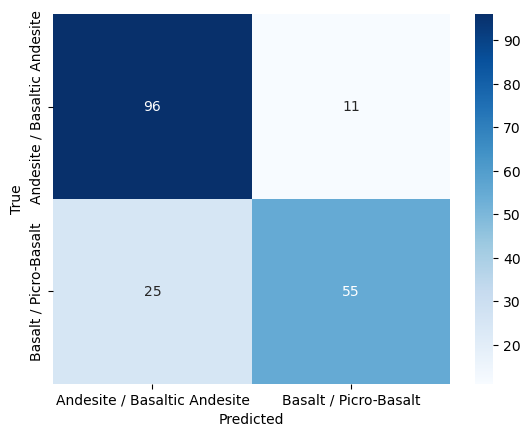

In [67]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Feature importance

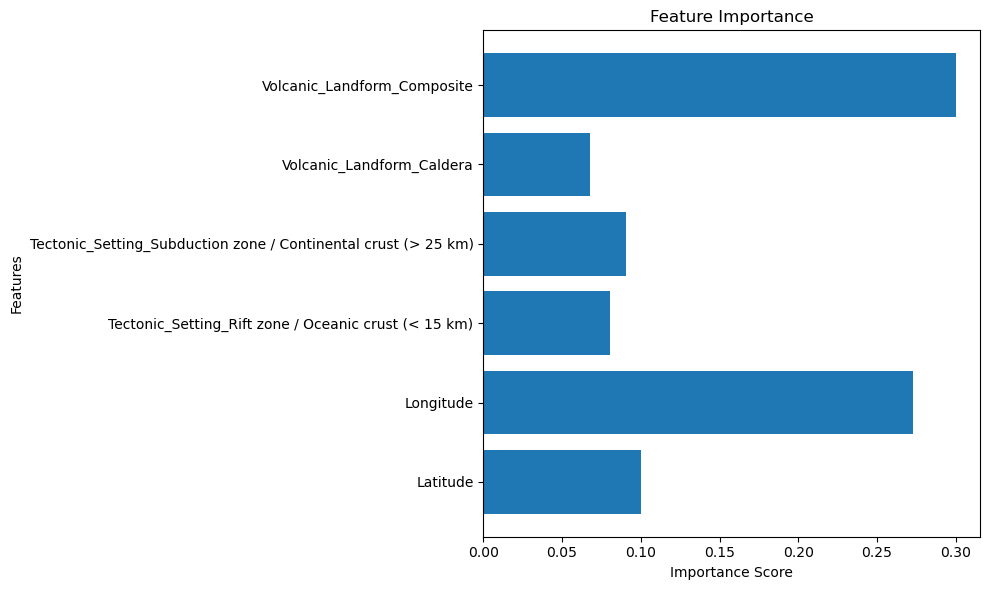

In [68]:
# compute the feature importance
feature_names = model.named_steps['preprocessor'].transformers_[0][2] + list(model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())

importance_scores = model.named_steps['classifier'].feature_importances_

# filter for features with importance > 5%
important_features = [(name, score) for name, score in zip(feature_names, importance_scores) if score > 0.05]

feature_names, importance_scores = zip(*important_features)

# Assuming you have feature_names and importance_scores
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance_scores)
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()